In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2" 


import torch_geometric
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, GraphUNet
from torch_geometric.data import Batch
from torch_geometric.utils import to_dense_adj
from tqdm import tqdm


from utils.data import GraphDataModule, save_prediction
from utils.training import train_model
from utils.metrics import evaluate_model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
data_module = GraphDataModule("./data", num_workers=1, batch_size=1)
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

Time taken to load ./data/hr_train.csv: 4.041863441467285 seconds
Time taken to load ./data/lr_train.csv: 0.5944335460662842 seconds
Time taken to load ./data/lr_test.csv: 0.43230533599853516 seconds


Converting vectors to graphs: 100%|██████████| 112/112 [00:50<00:00,  2.21it/s]


In [ ]:
from torch.nn import Linear, BatchNorm1d, Dropout, TransformerEncoder, TransformerEncoderLayer
from torch_geometric.nn import GATConv, GCNConv, GINConv, global_add_pool

class TopologyAwareGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.2):
        super(TopologyAwareGNN, self).__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.lns = nn.ModuleList()
        self.dropout = dropout
        
        # First layer with GCN for local neighborhood aggregation
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.lns.append(Linear(hidden_channels+in_channels, hidden_channels))
        self.bns.append(BatchNorm1d(hidden_channels))
        
        # Middle layers with GAT for capturing node importance
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.lns.append(Linear(2*hidden_channels, hidden_channels))
            self.bns.append(BatchNorm1d(hidden_channels))
        
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, batch):
        x, edge_index, edge_weight = batch.x, batch.edge_index, batch.edge_attr
        for conv, ln, bn in zip(self.convs, self.lns, self.bns):
            x2 = conv(x, edge_index, edge_weight)
            x = torch.concat((x, x2), dim=1)
            x = ln(x)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.lin(x)
        return x


class UpscalerGNN(nn.Module):
    def __init__(self, input_features, hidden_nodes, out_channels, attention_dim):
        super().__init__()
        self.input_nodes = 160
        self.output_nodes = 268
        
        self.layer1 = TopologyAwareGNN(input_features, 2*hidden_nodes, out_channels)
        self.layer2 = nn.Linear(self.output_nodes-self.input_nodes, out_channels)

        encoder_layer = TransformerEncoderLayer(d_model=out_channels, nhead=8)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=3)
                
        self.key = nn.Linear(out_channels, attention_dim)
        self.query = nn.Linear(out_channels, attention_dim)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, samples: Batch):
        X1 = self.layer1(samples)
                
        X2 = torch.eye(self.output_nodes-self.input_nodes).to(self.device)
        X2 = self.layer2(X2)
        
        
        X = torch.concat((X1, X2), dim=0)
        
        X = self.transformer(X.unsqueeze(1)).squeeze(1)
        
        K = self.key(X)
        Q = self.query(X)
        A = K @ Q.transpose(-1, -2)
        A = F.sigmoid(A)
        A = A.unsqueeze(0)
        
        return A


In [122]:
batch,target_batch = next(iter(train_loader))
input_dim = batch[0].x.shape[0]
output_dim = target_batch[0].x.shape[0]
input_features = batch[0].x.shape[1]
print(input_features,input_dim,output_dim)

8 160 268


In [128]:
model = UpscalerGNN(
    input_features=input_features,
    hidden_nodes=128, 
    out_channels=32, 
    attention_dim=16
).to(device)

In [ ]:
criterion = nn.L1Loss()

train_loss_history, val_loss_history, lr_history, best_model_state_dict = train_model(
    model=model, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader,
    criterion=criterion,
    num_epochs=100,
)

 22%|██▏       | 22/100 [00:51<03:00,  2.31s/it, train_loss=0.74, val_loss=0.746, lr=0.001]

In [104]:
model.load_state_dict(best_model_state_dict)
loss = evaluate_model(model, val_loader)
print(loss)

torch.save(model, 'model.pth')

0.1877501


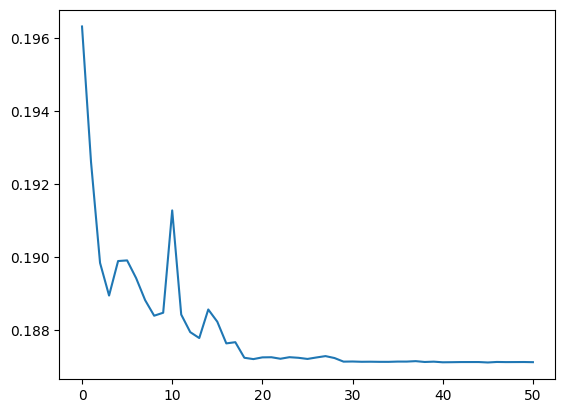

In [105]:
plt.plot(train_loss_history)
plt.show()

In [54]:
model = torch.load("model.pth", weights_only=False)

In [55]:
test_dataloader = data_module.test_dataloader()

In [57]:
submission_file = "outputs/test/submission.csv"
save_prediction(model, test_dataloader, submission_file)

(112, 0)


In [ ]:
df = pd.read_csv(submission_file)

In [ ]:
#!kaggle competitions submit -c dgl-2025-brain-graph-super-resolution-challenge -f outputs/test/submission.csv -m "test"
